In [2]:
%load_ext autoreload
%autoreload 2

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# EDA

Exploratory data analysis

In [4]:
# Load datasets

df_train = pd.read_csv("./data/train.csv")
df_valid = pd.read_csv("./data/valid.csv")

print(f"Training cases: {len(df_train)}    Validation cases: {len(df_valid)}")

Training cases: 225088    Validation cases: 28136


In [5]:
df_train.head(5)

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
0,2019-01-09 14:10:00,1591.839,141.928,11.5,74.428,0.0,1819.695,341.330021,10.0,-4417.4
1,2019-01-09 14:15:00,1591.839,141.928,11.5,74.428,0.0,1819.695,330.114330,10.0,-4417.4
2,2019-01-09 14:20:00,1591.839,141.928,11.5,74.428,0.0,1819.695,323.877221,10.0,-4417.4
3,2019-01-09 14:25:00,1591.839,141.928,11.5,74.428,0.0,1819.695,296.438463,10.0,-4417.4
4,2019-01-09 14:30:00,1591.839,141.928,11.5,74.428,0.0,1819.695,269.097132,10.0,-4417.4


We see that the time interval is 5 minutes. The training data starts 19th of January 2019 at 14:10:00

In [6]:
df_valid.head(5)

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
0,2021-03-01 03:30:00,1942.49,191.881,20.1,106.431,0.0,2266.102,52.119595,0.0,-2252.9
1,2021-03-01 03:35:00,1942.49,191.881,20.1,106.431,0.0,2266.102,90.374541,0.0,-2252.9
2,2021-03-01 03:40:00,1942.49,191.881,20.1,106.431,0.0,2266.102,88.435063,0.0,-2252.9
3,2021-03-01 03:45:00,1942.49,191.881,20.1,106.431,0.0,2266.102,53.375518,0.0,-2252.9
4,2021-03-01 03:50:00,1942.49,191.881,20.1,106.431,0.0,2266.102,65.496683,0.0,-2252.9


The validation data starts 1st of March 2021 at 03:30:00, which is the next timestep after the training set ends.

Instead of using the start_time as time variable, we introduce a variable t. t=0 is the 19th of January 2019 at 14:10:00, and increases by 1 for each 5 minutes. 

In [5]:
df_train['t'] = df_train.index
df_valid['t'] = df_valid.index + len(df_train)
valid_index = len(df_train)

To make things a little bit easier, we will to the EDA on a merged dataset.

In [6]:
df = df_train.append(df_valid, ignore_index=True)

C:\Users\joste\AppData\Local\Temp\ipykernel_70524\2564866483.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_train.append(df_valid, ignore_index=True)


## Variables

Let us look at some statistics for the different variables.

In [9]:
df.describe()

,hydro,micro,thermal,wind,river,total,y,sys_reg,flow,t
count,253224.000000,253224.000000,253224.000000,253224.000000,253224.0,253224.000000,253224.000000,253224.000000,253224.000000,253224.00000
mean,1881.092565,222.391459,21.181322,57.021133,0.0,2181.691454,5.687162,-8.208926,-1993.421635,126611.50000
std,406.298541,59.606814,4.626663,48.128498,0.0,450.031718,389.910506,42.332445,1282.716413,73099.61662
min,203.848000,36.002000,0.000000,0.000000,0.0,263.138000,-56379.459763,-828.000000,-5541.200000,0.00000
25%,1607.467000,180.311000,20.500000,15.961000,0.0,1891.512000,-135.839573,0.000000,-2935.000000,63305.75000
50%,1919.577000,220.469000,22.100000,42.962000,0.0,2228.355000,-5.781307,0.000000,-2012.005000,126611.50000
75%,2172.373000,268.814000,23.100000,91.256000,0.0,2495.213000,127.202385,0.000000,-920.900000,189917.25000
max,2995.524000,349.271000,25.700000,180.000000,0.0,3351.974000,2956.333317,474.000000,723.400000,253223.00000


### The target variable: y

We want to predict the variable y, which is the estimated ”open loop” power
grid imbalance at time step t. Let us have a look at the values for y.

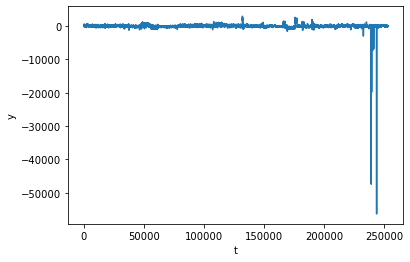

In [10]:
sns.lineplot(data=df, x='t', y='y' ) # Complete dataset
plt.show()

It appears that we have some outliers in the dataset. Given that the total power production is in the range of 10^3, it should be safe to assume that these are wrong values. 

In [11]:
df[df['y'] < -5000] 

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow,t
239255,2021-04-19 08:05:00,1720.256,178.419,20.1,17.069,0.0,1935.844,-11134.172366,0.0,-2217.50,239255
239256,2021-04-19 08:10:00,1720.256,178.419,20.1,17.069,0.0,1935.844,-39017.080774,0.0,-2217.50,239256
239257,2021-04-19 08:15:00,1720.256,178.419,20.1,17.069,0.0,1935.844,-47449.021916,0.0,-2217.50,239257
239258,2021-04-19 08:20:00,1720.256,178.419,20.1,17.069,0.0,1935.844,-15023.245419,0.0,-2217.50,239258
239590,2021-04-20 12:00:00,1530.658,180.064,20.1,54.909,0.0,1785.731,-19848.287205,0.0,-1840.28,239590
239591,2021-04-20 12:05:00,1530.658,180.064,20.1,54.909,0.0,1785.731,-9920.642511,0.0,-1812.50,239591
240459,2021-04-23 12:25:00,1239.589,176.324,20.1,117.094,0.0,1553.107,-7291.023308,0.0,-2626.60,240459
241298,2021-04-26 10:20:00,1687.963,175.531,20.1,52.104,0.0,1935.698,-6851.170808,0.0,-2598.90,241298
243730,2021-05-04 21:00:00,1194.585,148.296,20.1,164.832,0.0,1527.813,-56379.459763,0.0,-2496.68,243730
243731,2021-05-04 21:05:00,1194.585,148.296,20.1,164.832,0.0,1527.813,-49624.840806,0.0,-2444.90,243731


It seems like the outliers happens in consecutive places. Let's investigate further.

In [12]:
df[239253:239262]

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow,t
239253,2021-04-19 07:55:00,1731.179,178.282,20.1,22.451,0.0,1952.012,36.264906,0.0,-2327.74,239253
239254,2021-04-19 08:00:00,1720.256,178.419,20.1,17.069,0.0,1935.844,-32.140504,0.0,-2258.84,239254
239255,2021-04-19 08:05:00,1720.256,178.419,20.1,17.069,0.0,1935.844,-11134.172366,0.0,-2217.50,239255
239256,2021-04-19 08:10:00,1720.256,178.419,20.1,17.069,0.0,1935.844,-39017.080774,0.0,-2217.50,239256
239257,2021-04-19 08:15:00,1720.256,178.419,20.1,17.069,0.0,1935.844,-47449.021916,0.0,-2217.50,239257
239258,2021-04-19 08:20:00,1720.256,178.419,20.1,17.069,0.0,1935.844,-15023.245419,0.0,-2217.50,239258
239259,2021-04-19 08:25:00,1720.256,178.419,20.1,17.069,0.0,1935.844,-362.716800,0.0,-2217.50,239259
239260,2021-04-19 08:30:00,1720.256,178.419,20.1,17.069,0.0,1935.844,52.538523,0.0,-2217.50,239260
239261,2021-04-19 08:35:00,1720.256,178.419,20.1,17.069,0.0,1935.844,109.085608,0.0,-2217.50,239261


The values must clearly be wrong. For now, we go for the easy option and just set them to the mean.

In [7]:
df.loc[df['y'] < -5000, 'y'] = 5.687162	# Set wrong values to mean

Now, the plot should make more sense. 

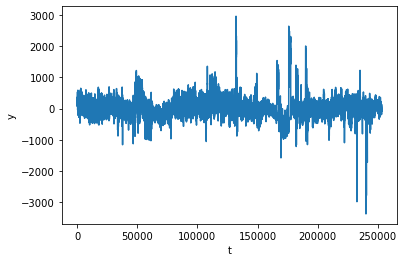

In [14]:
sns.lineplot(data=df, x='t', y='y' )
plt.show()

There are still some spikes, but these might be correct values. 

Let us visualize what we want to predict (the validation set).

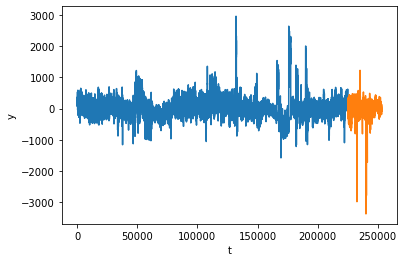

In [15]:
sns.lineplot(data=df[:valid_index], x='t', y='y', ) # Train set
sns.lineplot(data=df[valid_index:], x='t', y='y', ) # Valid set
plt.show()

Let us zoom in a little bit to see clearer

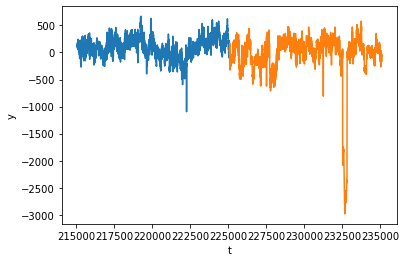

In [16]:
sns.lineplot(data=df[valid_index-10000:valid_index], x='t', y='y', ) # Train set
sns.lineplot(data=df[valid_index:valid_index+10000], x='t', y='y', ) # Valid set
plt.show()

### River

We see that all the river values are 0, so we can just remove this column

In [17]:
(df.river == 0).all()

True

In [8]:
df = df.drop(columns='river')

### Hydro
The planned reservoir hydropower production at the time step.

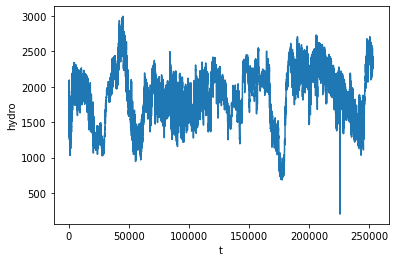

In [19]:
sns.lineplot(data=df, x='t', y='hydro' )
plt.show()

The Hydro data seams to have seasonal variation (which makes sense). It might seem like there are some outliers, we will investigate this.

In [20]:
df[df['hydro'] < 500]

,start_time,hydro,micro,thermal,wind,total,y,sys_reg,flow,t
225322,2021-03-01 23:00:00,206.688,36.104,23.1,0.0,265.892,-6.157932,0.0,-2238.6,225322
225323,2021-03-01 23:05:00,206.688,36.104,23.1,0.0,265.892,-11.859012,0.0,-2238.6,225323
225324,2021-03-01 23:10:00,206.688,36.104,23.1,0.0,265.892,37.148618,0.0,-2238.6,225324
225325,2021-03-01 23:15:00,206.688,36.104,23.1,0.0,265.892,52.905536,0.0,-2238.6,225325
225326,2021-03-01 23:20:00,206.688,36.104,23.1,0.0,265.892,78.877955,0.0,-2238.6,225326
...,...,...,...,...,...,...,...,...,...,...
225605,2021-03-02 22:35:00,204.680,36.032,23.1,0.0,263.812,235.117745,0.0,-2590.7,225605
225606,2021-03-02 22:40:00,204.680,36.032,23.1,0.0,263.812,250.940728,0.0,-2590.7,225606
225607,2021-03-02 22:45:00,204.680,36.032,23.1,0.0,263.812,271.343005,0.0,-2590.7,225607
225608,2021-03-02 22:50:00,204.680,36.032,23.1,0.0,263.812,296.410174,0.0,-2590.7,225608


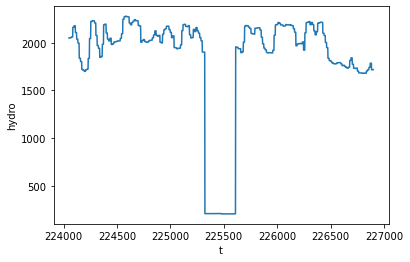

In [21]:
sns.lineplot(data=df[224050:226900], x='t', y='hydro' )
plt.show()

This seems a little off. We will leave it for now, but keep it in mind.

### Micro
The planned small-scale hydropower production at the time step.

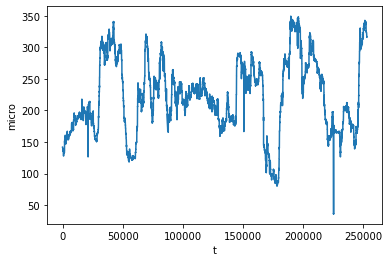

In [22]:
sns.lineplot(data=df, x='t', y='micro' )
plt.show()

Micro seems to have a drop in the same area as hydro. Maybe something happened in that time-range?

### Thermal
The planned thermal power plant production at the time step.


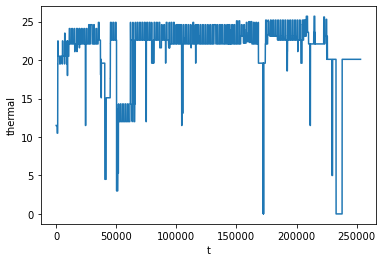

In [23]:
sns.lineplot(data=df, x='t', y='thermal' )
plt.show()

Nothing very special here

### Wind
The planned wind power plant production at the time step.

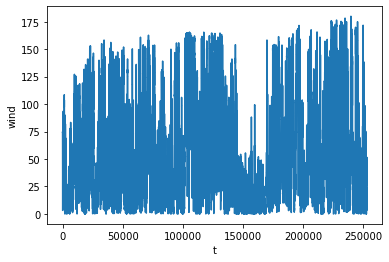

In [24]:
sns.lineplot(data=df, x='t', y='wind' )
plt.show()

Very high variance. Seems like there is a period with little wind in the range [140000, 160000]

### Total
The total planned energy production. Equal to the sum of the other planned production features.

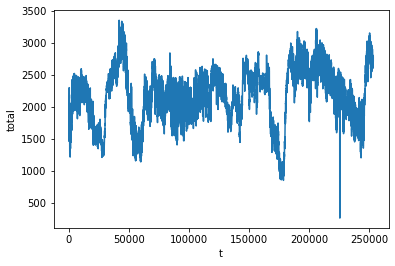

In [25]:
sns.lineplot(data=df, x='t', y='total' )
plt.show()

As expected, this follow the same curve as the hydro power since hydro by far is the largest source of energy.

### Sys_reg
The planned ”system regulation” at the time step: activation of balancing services to accommodate
specific needs (e.g. bottlenecks) in the power system.


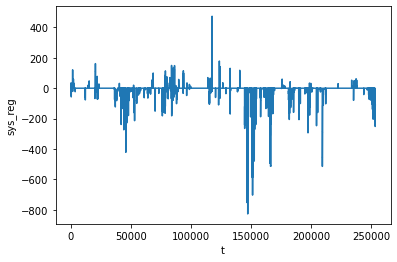

In [26]:
sns.lineplot(data=df, x='t', y='sys_reg' )
plt.show()

### Flow
The planned total power flow in or out of the current area of the grid at the time step. At any moment,
power flows between connected bidding areas. This value is the net power flow when considering export to be
negative and import to be positive relative to the current area.

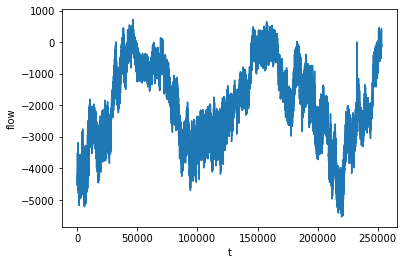

In [27]:
sns.lineplot(data=df, x='t', y='flow' )
plt.show()

It looks like the signs are swapped, so import is negative and export positive. We cannot export 5000 if the total production is 1500

## Correlation

Let us investigate the correlation between variables. We are mainly interested in correlation with y

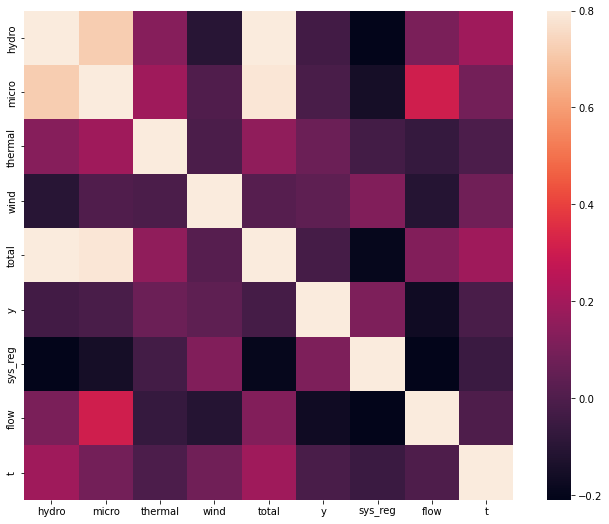

In [29]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.8, square=True)
plt.show()

It seems like sys_reg actually has the highest positive correlation with y, and flow has the most negative correlation.

## Feature engineering

We can introduce more features to help the model. 

### Date features

- time_of_day: The hour of the day 
- time_of_week: The day of the week
- time_of_year: The season

In [35]:
dt = df.start_time.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') )
df['time_of_day']= dt.apply(lambda x: x.hour)
df['time_of_week']= dt.apply(lambda x: x.weekday())
df['time_of_year']= dt.apply(lambda x: x.month % 12 // 3 + 1)
# df['day']= dt.apply(lambda x: x.day)
# df['month']= dt.apply(lambda x: x.month)

In [45]:
df.head()

,start_time,hydro,micro,thermal,wind,total,y,sys_reg,flow,t,time_of_day,time_of_week,time_of_year
0,2019-01-09 14:10:00,1591.839,141.928,11.5,74.428,1819.695,341.330021,10.0,-4417.4,0,14,2,1
1,2019-01-09 14:15:00,1591.839,141.928,11.5,74.428,1819.695,330.114330,10.0,-4417.4,1,14,2,1
2,2019-01-09 14:20:00,1591.839,141.928,11.5,74.428,1819.695,323.877221,10.0,-4417.4,2,14,2,1
3,2019-01-09 14:25:00,1591.839,141.928,11.5,74.428,1819.695,296.438463,10.0,-4417.4,3,14,2,1
4,2019-01-09 14:30:00,1591.839,141.928,11.5,74.428,1819.695,269.097132,10.0,-4417.4,4,14,2,1
